**Outline of Steps**
    + Initialization
        + Download COCO detection data from http://cocodataset.org/#download
            + http://images.cocodataset.org/zips/train2014.zip <= train images
            + http://images.cocodataset.org/zips/val2014.zip <= validation images
            + http://images.cocodataset.org/annotations/annotations_trainval2014.zip <= train and validation annotations
        + Run this script to convert annotations in COCO format to VOC format
            + https://gist.github.com/chicham/6ed3842d0d2014987186#file-coco2pascal-py
        + Download pre-trained weights from https://pjreddie.com/darknet/yolo/
            + https://pjreddie.com/media/files/yolo.weights
        + Specify the directory of train annotations (train_annot_folder) and train images (train_image_folder)
        + Specify the directory of validation annotations (valid_annot_folder) and validation images (valid_image_folder)
        + Specity the path of pre-trained weights by setting variable *wt_path*
    + Construct equivalent network in Keras
        + Network arch from https://github.com/pjreddie/darknet/blob/master/cfg/yolo-voc.cfg
    + Load the pretrained weights
    + Perform training 
    + Perform detection on an image with newly trained weights
    + Perform detection on an video with newly trained weights

# Initialization

In [1]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from tqdm import tqdm
from imgaug import augmenters as iaa
import numpy as np
import pickle
import os, cv2
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes, normalize, get_boxes_data
import h5py

#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

%matplotlib inline

Using TensorFlow backend.


ModuleNotFoundError: No module named 'preprocessing'

In [2]:
LABELS = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

# Construct the network

In [4]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [5]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

# Perform training

**Loss function**

$$\begin{multline}
\lambda_\textbf{coord}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
     L_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
\\
+ \lambda_\textbf{coord} 
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
         L_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
\\
+ \sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
        L_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \lambda_\textrm{noobj}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
    L_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \sum_{i = 0}^{S^2}
L_i^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{multline}$$

In [10]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

# Perform detection on image

In [16]:

model.load_weights("weights_coco.h5")

#model.load_weights("yolo.weights")

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

time_taken is 0:00:00.055621


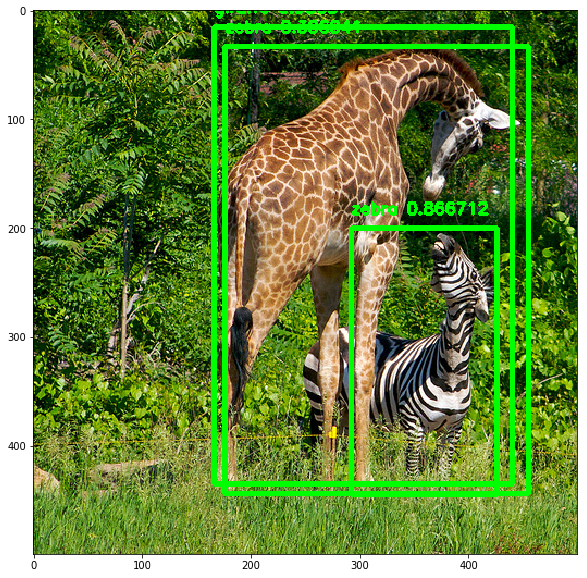

In [17]:
from datetime import datetime

time_start=datetime.now()
image = cv2.imread('images/giraffe.jpg')

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
image = draw_boxes(image, boxes, labels=LABELS)

print("time_taken is", datetime.now() - time_start)

plt.imshow(image[:,:,::-1]); plt.show()

# Perform detection on video

In [18]:
model.load_weights("weights_coco.h5")

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

In [25]:
#video_inp = '/media/karthik/Windows/Users/kvvip/Udacity_MLND/Capstone/tennis/tennis_vedios/main1.mp4'
#video_out = '/media/karthik/Windows/Users/kvvip/Udacity_MLND/Capstone/tennis/tennis_vedios/main1_10fps.mp4'

video_inp = 'C:\\Users\\kvvip\\Udacity_MLND\\Capstone\\tennis\\tennis_vedios\\main1.mp4'
video_out ='C:\\Users\\kvvip\\Udacity_MLND\\Capstone\\tennis\\tennis_vedios\\main1_10fps.mp4'


video_reader = cv2.VideoCapture(video_inp)

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
print(nb_frames, frame_h, frame_w)

video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'XVID'), 
                               10.0, 
                               (frame_w, frame_h))

for i in tqdm(range(nb_frames)):
    ret, image = video_reader.read()
    """
    input_image = cv2.resize(image, (416, 416))
    input_image = input_image / 255.
    #print(input_image.shape)
    input_image = input_image[:,:,::-1]
    #print(input_image.shape)
    input_image = np.expand_dims(input_image, 0)
    #print(input_image.shape)
    netout = model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=0.5,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    image = draw_boxes(image, boxes, labels=LABELS)
    """
    video_writer.write(np.uint8(image))
    
video_reader.release()
video_writer.release()


13230 360 640


'\nvideo_writer = cv2.VideoWriter(video_out,\n                               cv2.VideoWriter_fourcc(*\'XVID\'), \n                               10.0, \n                               (frame_w, frame_h))\n\nfor i in tqdm(range(nb_frames)):\n    ret, image = video_reader.read()\n    ""1"\n    input_image = cv2.resize(image, (416, 416))\n    input_image = input_image / 255.\n    #print(input_image.shape)\n    input_image = input_image[:,:,::-1]\n    #print(input_image.shape)\n    input_image = np.expand_dims(input_image, 0)\n    #print(input_image.shape)\n    netout = model.predict([input_image, dummy_array])\n\n    boxes = decode_netout(netout[0], \n                          obj_threshold=0.5,\n                          nms_threshold=NMS_THRESHOLD,\n                          anchors=ANCHORS, \n                          nb_class=CLASS)\n    image = draw_boxes(image, boxes, labels=LABELS)\n    ""1"\n    video_writer.write(np.uint8(image))\n    \nvideo_reader.release()\nvideo_writer.releas

In [52]:
import pandas as pd

df=pd.read_csv("C:\\Users\\kvvip\\Udacity_MLND\\Capstone\\tennis\\tennis_vedios\\main1.csv")
print(df)

video_capture=cv2.VideoCapture("C:\\Users\\kvvip\\Udacity_MLND\\Capstone\\tennis\\tennis_vedios\\main1_10fps.mp4")

total_videos= len(df.index)

i=0
serve_count = 0
forehand_count = 0
backhand_count =0
label_modify = 0

for i in tqdm(range(total_videos)):


    frame_h = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_w = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    
    labels_array= np.array(df["Label"])
    
    if str(labels_array[i]) == "serve":
        label_modify = serve_count
        serve_count +=1
        
    if str(labels_array[i]) == "forehand":
        label_modify = forehand_count
        forehand_count +=1
        
    if str(labels_array[i]) == "backhand":
        label_modify = backhand_count
        backhand_count +=1
        

    

    video_out="C:\\Users\\kvvip\\Udacity_MLND\\Capstone\\tennis\\tennis_vedios\\"+str(labels_array[i])+"\\"+str(label_modify)+".mp4"

    start_frame = 10*(int(df.iloc[[i]]["Start-hour"])*3600+
                            int(df.iloc[[i]]["Start-min"])*60+
                            int(df.iloc[[i]]["Start-sec"]))

    end_frame = 10*(int(df.iloc[[i]]["End-hour"])*3600+
                            int(df.iloc[[i]]["End-min"])*60+
                            int(df.iloc[[i]]["End-sec"]) + 1)

    video_writer = cv2.VideoWriter(video_out,
                                   cv2.VideoWriter_fourcc(*'XVID'), 
                                   10.0, 
                                   (frame_w, frame_h))

    print("start and end frames",start_frame, end_frame)
    for frame in range(start_frame,end_frame):
        video_capture.set(1, frame)
        res, image = video_capture.read()
        video_writer.write(np.uint8(image))
    video_reader.release()
    video_writer.release()



       Label  Start-hour  Start-min  Start-sec  End-hour  End-min  End-sec
0      serve           0          0         41         0        0       50
1      serve           0          0         52         0        0       57
2      serve           0          1          5         0        1       14
3   forehand           0          1         21         0        1       23
4   backhand           0          1         31         0        1       33
5      serve           0          1         43         0        1       48
6   backhand           0          1         55         0        1       57
7      serve           0          2          2         0        2        9
8   backhand           0          2         17         0        2       19
9      serve           0          2         26         0        2       33
10  forehand           0          2         38         0        2       40
11  forehand           0          2         48         0        2       50
12     serve           0 

  0%|                                                                                           | 0/88 [00:00<?, ?it/s]

start and end frames 410 510


  1%|▉                                                                                  | 1/88 [00:00<00:39,  2.22it/s]

start and end frames 520 580


  2%|█▉                                                                                 | 2/88 [00:00<00:31,  2.77it/s]

start and end frames 650 750


  3%|██▊                                                                                | 3/88 [00:01<00:33,  2.50it/s]

start and end frames 810 840


  5%|███▊                                                                               | 4/88 [00:01<00:28,  2.99it/s]

start and end frames 910 940


  6%|████▋                                                                              | 5/88 [00:01<00:24,  3.33it/s]

start and end frames 1030 1090


  7%|█████▋                                                                             | 6/88 [00:01<00:24,  3.39it/s]

start and end frames 1150 1180


  8%|██████▌                                                                            | 7/88 [00:01<00:22,  3.65it/s]

start and end frames 1220 1300


  9%|███████▌                                                                           | 8/88 [00:02<00:22,  3.50it/s]

start and end frames 1370 1400


 10%|████████▍                                                                          | 9/88 [00:02<00:21,  3.72it/s]

start and end frames 1460 1540


 11%|█████████▎                                                                        | 10/88 [00:02<00:22,  3.55it/s]

start and end frames 1580 1610


 12%|██████████▎                                                                       | 11/88 [00:02<00:20,  3.72it/s]

start and end frames 1680 1710


 14%|███████████▏                                                                      | 12/88 [00:03<00:19,  3.87it/s]

start and end frames 1820 1920


 15%|████████████                                                                      | 13/88 [00:03<00:20,  3.67it/s]

start and end frames 1970 2050


 16%|█████████████                                                                     | 14/88 [00:03<00:20,  3.59it/s]

start and end frames 2120 2210


 17%|█████████████▉                                                                    | 15/88 [00:04<00:20,  3.49it/s]

start and end frames 2250 2280


 18%|██████████████▉                                                                   | 16/88 [00:04<00:20,  3.59it/s]

start and end frames 2350 2410


 19%|███████████████▊                                                                  | 17/88 [00:04<00:19,  3.60it/s]

start and end frames 2480 2510


 20%|████████████████▊                                                                 | 18/88 [00:04<00:18,  3.70it/s]

start and end frames 2570 2600


 22%|█████████████████▋                                                                | 19/88 [00:05<00:18,  3.79it/s]

start and end frames 2700 2790


 23%|██████████████████▋                                                               | 20/88 [00:05<00:18,  3.70it/s]

start and end frames 2850 2870
start and end frames 2940 3010


 25%|████████████████████▌                                                             | 22/88 [00:05<00:17,  3.78it/s]

start and end frames 3050 3080


 26%|█████████████████████▍                                                            | 23/88 [00:05<00:16,  3.86it/s]

start and end frames 3170 3200


 27%|██████████████████████▎                                                           | 24/88 [00:06<00:16,  3.93it/s]

start and end frames 3590 3650


 28%|███████████████████████▎                                                          | 25/88 [00:06<00:16,  3.92it/s]

start and end frames 3750 3810


 30%|████████████████████████▏                                                         | 26/88 [00:06<00:15,  3.92it/s]

start and end frames 3850 3880


 31%|█████████████████████████▏                                                        | 27/88 [00:06<00:15,  3.99it/s]

start and end frames 4000 4060


 32%|██████████████████████████                                                        | 28/88 [00:07<00:15,  3.97it/s]

start and end frames 4120 4150


 33%|███████████████████████████                                                       | 29/88 [00:07<00:14,  4.03it/s]

start and end frames 4250 4280


 34%|███████████████████████████▉                                                      | 30/88 [00:07<00:14,  4.09it/s]

start and end frames 4340 4370


 35%|████████████████████████████▉                                                     | 31/88 [00:07<00:13,  4.14it/s]

start and end frames 4420 4450


 36%|█████████████████████████████▊                                                    | 32/88 [00:07<00:13,  4.19it/s]

start and end frames 4530 4560


 38%|██████████████████████████████▊                                                   | 33/88 [00:07<00:12,  4.24it/s]

start and end frames 4620 4650


 39%|███████████████████████████████▋                                                  | 34/88 [00:07<00:12,  4.29it/s]

start and end frames 4840 4900


 40%|████████████████████████████████▌                                                 | 35/88 [00:08<00:12,  4.27it/s]

start and end frames 4940 4970


 41%|█████████████████████████████████▌                                                | 36/88 [00:08<00:12,  4.32it/s]

start and end frames 5060 5090


 42%|██████████████████████████████████▍                                               | 37/88 [00:08<00:11,  4.36it/s]

start and end frames 5410 5440


 43%|███████████████████████████████████▍                                              | 38/88 [00:08<00:11,  4.40it/s]

start and end frames 5490 5520


 44%|████████████████████████████████████▎                                             | 39/88 [00:08<00:11,  4.44it/s]

start and end frames 5590 5620


 45%|█████████████████████████████████████▎                                            | 40/88 [00:08<00:10,  4.48it/s]

start and end frames 5680 5710


 47%|██████████████████████████████████████▏                                           | 41/88 [00:09<00:10,  4.52it/s]

start and end frames 5760 5690
start and end frames 6000 6030


 49%|████████████████████████████████████████                                          | 43/88 [00:09<00:09,  4.66it/s]

start and end frames 6100 6130


 50%|█████████████████████████████████████████                                         | 44/88 [00:09<00:09,  4.70it/s]

start and end frames 6360 6390


 51%|█████████████████████████████████████████▉                                        | 45/88 [00:09<00:09,  4.73it/s]

start and end frames 6440 6460


 52%|██████████████████████████████████████████▊                                       | 46/88 [00:09<00:08,  4.78it/s]

start and end frames 6530 6560


 53%|███████████████████████████████████████████▊                                      | 47/88 [00:09<00:08,  4.81it/s]

start and end frames 6750 6780


 55%|████████████████████████████████████████████▋                                     | 48/88 [00:09<00:08,  4.84it/s]

start and end frames 6840 6870


 56%|█████████████████████████████████████████████▋                                    | 49/88 [00:10<00:07,  4.88it/s]

start and end frames 7250 7280


 57%|██████████████████████████████████████████████▌                                   | 50/88 [00:10<00:07,  4.90it/s]

start and end frames 7340 7370


 58%|███████████████████████████████████████████████▌                                  | 51/88 [00:10<00:07,  4.93it/s]

start and end frames 7720 7750


 59%|████████████████████████████████████████████████▍                                 | 52/88 [00:10<00:07,  4.96it/s]

start and end frames 7810 7850


 60%|█████████████████████████████████████████████████▍                                | 53/88 [00:10<00:07,  4.96it/s]

start and end frames 8020 8050


 61%|██████████████████████████████████████████████████▎                               | 54/88 [00:10<00:06,  4.98it/s]

start and end frames 8110 8050
start and end frames 8280 8310


 64%|████████████████████████████████████████████████████▏                             | 56/88 [00:10<00:06,  5.09it/s]

start and end frames 8360 8390


 65%|█████████████████████████████████████████████████████                             | 57/88 [00:11<00:06,  5.12it/s]

start and end frames 8450 8480


 66%|██████████████████████████████████████████████████████                            | 58/88 [00:11<00:05,  5.14it/s]

start and end frames 8610 8640


 67%|██████████████████████████████████████████████████████▉                           | 59/88 [00:11<00:05,  5.16it/s]

start and end frames 8710 8750


 68%|███████████████████████████████████████████████████████▉                          | 60/88 [00:11<00:05,  5.16it/s]

start and end frames 8930 8970


 69%|████████████████████████████████████████████████████████▊                         | 61/88 [00:11<00:05,  5.16it/s]

start and end frames 9320 9390


 70%|█████████████████████████████████████████████████████████▊                        | 62/88 [00:12<00:05,  5.11it/s]

start and end frames 9440 9480


 72%|██████████████████████████████████████████████████████████▋                       | 63/88 [00:12<00:04,  5.12it/s]

start and end frames 9560 9640


 73%|███████████████████████████████████████████████████████████▋                      | 64/88 [00:12<00:04,  5.05it/s]

start and end frames 9690 9720


 74%|████████████████████████████████████████████████████████████▌                     | 65/88 [00:12<00:04,  5.07it/s]

start and end frames 9770 9800


 75%|█████████████████████████████████████████████████████████████▌                    | 66/88 [00:12<00:04,  5.09it/s]

start and end frames 9910 9990


 76%|██████████████████████████████████████████████████████████████▍                   | 67/88 [00:13<00:04,  5.03it/s]

start and end frames 10110 10180


 77%|███████████████████████████████████████████████████████████████▎                  | 68/88 [00:13<00:04,  4.99it/s]

start and end frames 10220 10250


 78%|████████████████████████████████████████████████████████████████▎                 | 69/88 [00:13<00:03,  5.00it/s]

start and end frames 10310 10350


 80%|█████████████████████████████████████████████████████████████████▏                | 70/88 [00:13<00:03,  5.01it/s]

start and end frames 10420 10460


 81%|██████████████████████████████████████████████████████████████████▏               | 71/88 [00:14<00:03,  5.01it/s]

start and end frames 10500 10560


 82%|███████████████████████████████████████████████████████████████████               | 72/88 [00:14<00:03,  4.99it/s]

start and end frames 10600 10630


 83%|████████████████████████████████████████████████████████████████████              | 73/88 [00:14<00:02,  5.01it/s]

start and end frames 10690 10720


 84%|████████████████████████████████████████████████████████████████████▉             | 74/88 [00:14<00:02,  5.02it/s]

start and end frames 10790 10820


 85%|█████████████████████████████████████████████████████████████████████▉            | 75/88 [00:14<00:02,  5.04it/s]

start and end frames 10890 10960


 86%|██████████████████████████████████████████████████████████████████████▊           | 76/88 [00:15<00:02,  5.00it/s]

start and end frames 11050 11130


 88%|███████████████████████████████████████████████████████████████████████▊          | 77/88 [00:15<00:02,  4.95it/s]

start and end frames 11160 11190


 89%|████████████████████████████████████████████████████████████████████████▋         | 78/88 [00:15<00:02,  4.97it/s]

start and end frames 11310 11390


 90%|█████████████████████████████████████████████████████████████████████████▌        | 79/88 [00:16<00:01,  4.92it/s]

start and end frames 11430 11460


 91%|██████████████████████████████████████████████████████████████████████████▌       | 80/88 [00:16<00:01,  4.94it/s]

start and end frames 11580 11650


 92%|███████████████████████████████████████████████████████████████████████████▍      | 81/88 [00:16<00:01,  4.90it/s]

start and end frames 11710 11770


 93%|████████████████████████████████████████████████████████████████████████████▍     | 82/88 [00:16<00:01,  4.88it/s]

start and end frames 11800 11830


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 83/88 [00:16<00:01,  4.90it/s]

start and end frames 11880 11960


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 84/88 [00:17<00:00,  4.85it/s]

start and end frames 12030 12070


 97%|███████████████████████████████████████████████████████████████████████████████▏  | 85/88 [00:17<00:00,  4.86it/s]

start and end frames 12220 12290


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 86/88 [00:17<00:00,  4.82it/s]

start and end frames 12330 12360


 99%|█████████████████████████████████████████████████████████████████████████████████ | 87/88 [00:17<00:00,  4.84it/s]

start and end frames 12420 12450


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:18<00:00,  4.85it/s]


In [31]:
print(range(20))

range(0, 20)


In [17]:
import glob



curr_dir = os.getcwd()
print(curr_dir)
chg_dir="/media/karthik/Windows/Users/kvvip/Udacity_MLND/Capstone/tennis/tennis_JPG/good_qual/"
os.chdir(chg_dir)
imagenames_list=glob.glob("image*")
print("length of list = ", len(imagenames_list))
#imagenames_list_ = [f for f in imagenames_list if int(f.replace("image","").replace(".jpg","")) >= 8052 and int(f.replace("image","").replace(".jpg","")) < 26000]
imagenames_list_=[]
print("lengt of new list = ", len(imagenames_list_))
os.chdir(curr_dir)
out_txt_dir='/media/karthik/Windows/Users/kvvip/Udacity_MLND/Capstone/Capstone/Yolo_car_detection/out_data/'
count=0

for image_file_custom in tqdm(imagenames_list_):
    
    count +=1
    
    time_start=datetime.now()
    image = cv2.imread(chg_dir + image_file_custom)
    #print(image_file_custom)
    #plt.imshow(image)
    input_image = cv2.resize(image, (416, 416))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    netout = model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=OBJ_THRESHOLD,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    
    end_time2=datetime.now()
    #print("second part:", end_time2-time_start)
    
    if count %1000 == 1:
        #print(image_file_custom)
        print('Found {} boxes for {}'.format(len(boxes), image_file_custom))
        print("time taken for this image:", end_time2-time_start)
    top3_persons = get_boxes_data(image, boxes, labels=LABELS)

    with open(out_txt_dir+image_file_custom+'.txt', "w") as file:
        for line in top3_persons:
            file.writelines(str(line)+"\n")
    
    
count =0 

  0%|          | 2/17149 [00:00<14:52, 19.22it/s]

/media/karthik/Windows/Users/kvvip/Udacity_MLND/basic-yolo-keras
length of list =  25200
lengt of new list =  17149
Found 4 boxes for image0000008052.jpg
time taken for this image: 0:00:00.054287


  1%|          | 104/17149 [00:04<12:27, 22.80it/s]

Found 3 boxes for image0000008158.jpg
time taken for this image: 0:00:00.044050


  1%|          | 203/17149 [00:08<12:25, 22.73it/s]

Found 13 boxes for image0000008249.jpg
time taken for this image: 0:00:00.046498


  2%|▏         | 305/17149 [00:13<12:20, 22.75it/s]

Found 2 boxes for image0000008355.jpg
time taken for this image: 0:00:00.041327


  2%|▏         | 404/17149 [00:17<12:15, 22.75it/s]

Found 4 boxes for image0000008373.jpg
time taken for this image: 0:00:00.041177


  3%|▎         | 503/17149 [00:22<12:09, 22.82it/s]

Found 5 boxes for image0000008552.jpg
time taken for this image: 0:00:00.044958


  4%|▎         | 605/17149 [00:26<12:06, 22.78it/s]

Found 4 boxes for image0000008658.jpg
time taken for this image: 0:00:00.039592


  4%|▍         | 704/17149 [00:30<12:01, 22.79it/s]

Found 3 boxes for image0000008749.jpg
time taken for this image: 0:00:00.041947


  5%|▍         | 803/17149 [00:35<11:55, 22.84it/s]

Found 3 boxes for image0000008855.jpg
time taken for this image: 0:00:00.042497


  5%|▌         | 905/17149 [00:39<11:52, 22.81it/s]

Found 2 boxes for image0000008961.jpg
time taken for this image: 0:00:00.050523


  6%|▌         | 1004/17149 [00:44<11:48, 22.80it/s]

Found 11 boxes for image0000009051.jpg
time taken for this image: 0:00:00.043332


  6%|▋         | 1103/17149 [00:48<11:44, 22.76it/s]

Found 3 boxes for image0000009158.jpg
time taken for this image: 0:00:00.049451


  7%|▋         | 1205/17149 [00:52<11:39, 22.79it/s]

Found 2 boxes for image0000009248.jpg
time taken for this image: 0:00:00.040198


  8%|▊         | 1304/17149 [00:57<11:33, 22.84it/s]

Found 2 boxes for image0000009354.jpg
time taken for this image: 0:00:00.049657


  8%|▊         | 1403/17149 [01:01<11:28, 22.86it/s]

Found 1 boxes for image0000009460.jpg
time taken for this image: 0:00:00.040203


  9%|▉         | 1505/17149 [01:05<11:23, 22.87it/s]

Found 1 boxes for image0000009551.jpg
time taken for this image: 0:00:00.042628


  9%|▉         | 1604/17149 [01:10<11:19, 22.89it/s]

Found 6 boxes for image0000009657.jpg
time taken for this image: 0:00:00.039887


 10%|▉         | 1703/17149 [01:14<11:14, 22.90it/s]

Found 6 boxes for image0000009763.jpg
time taken for this image: 0:00:00.050483


 11%|█         | 1805/17149 [01:18<11:09, 22.92it/s]

Found 6 boxes for image0000009854.jpg
time taken for this image: 0:00:00.040385


 11%|█         | 1904/17149 [01:23<11:05, 22.92it/s]

Found 2 boxes for image0000009960.jpg
time taken for this image: 0:00:00.040251


 12%|█▏        | 2003/17149 [01:27<11:00, 22.94it/s]

Found 7 boxes for image0000011025.jpg
time taken for this image: 0:00:00.043868


 12%|█▏        | 2105/17149 [01:31<10:56, 22.93it/s]

Found 2 boxes for image0000010142.jpg
time taken for this image: 0:00:00.045263


 13%|█▎        | 2204/17149 [01:36<10:51, 22.94it/s]

Found 3 boxes for image0000010248.jpg
time taken for this image: 0:00:00.040018


 13%|█▎        | 2303/17149 [01:40<10:47, 22.92it/s]

Found 11 boxes for image0000010338.jpg
time taken for this image: 0:00:00.047417


 14%|█▍        | 2405/17149 [01:44<10:43, 22.91it/s]

Found 3 boxes for image0000010444.jpg
time taken for this image: 0:00:00.052959


 15%|█▍        | 2504/17149 [01:49<10:39, 22.89it/s]

Found 5 boxes for image0000010551.jpg
time taken for this image: 0:00:00.046436


 15%|█▌        | 2603/17149 [01:53<10:35, 22.89it/s]

Found 5 boxes for image0000010641.jpg
time taken for this image: 0:00:00.041947


 16%|█▌        | 2705/17149 [01:58<10:30, 22.90it/s]

Found 4 boxes for image0000010747.jpg
time taken for this image: 0:00:00.042028


 16%|█▋        | 2804/17149 [02:02<10:26, 22.91it/s]

Found 10 boxes for image0000010853.jpg
time taken for this image: 0:00:00.046693


 17%|█▋        | 2903/17149 [02:06<10:21, 22.91it/s]

Found 5 boxes for image0000010944.jpg
time taken for this image: 0:00:00.041906


 18%|█▊        | 3005/17149 [02:11<10:17, 22.91it/s]

Found 6 boxes for image0000011050.jpg
time taken for this image: 0:00:00.040585


 18%|█▊        | 3104/17149 [02:15<10:12, 22.92it/s]

Found 0 boxes for image0000011140.jpg
time taken for this image: 0:00:00.038532


 19%|█▊        | 3203/17149 [02:19<10:08, 22.91it/s]

Found 11 boxes for image0000011247.jpg
time taken for this image: 0:00:00.051190


 19%|█▉        | 3305/17149 [02:24<10:03, 22.93it/s]

Found 2 boxes for image0000011353.jpg
time taken for this image: 0:00:00.039559


 20%|█▉        | 3404/17149 [02:28<09:59, 22.94it/s]

Found 2 boxes for image0000011443.jpg
time taken for this image: 0:00:00.039641


 20%|██        | 3503/17149 [02:32<09:54, 22.96it/s]

Found 2 boxes for image0000011549.jpg
time taken for this image: 0:00:00.041129


 21%|██        | 3605/17149 [02:36<09:49, 22.97it/s]

Found 6 boxes for image0000011603.jpg
time taken for this image: 0:00:00.039957


 22%|██▏       | 3704/17149 [02:41<09:45, 22.97it/s]

Found 2 boxes for image0000011746.jpg
time taken for this image: 0:00:00.043448


 22%|██▏       | 3803/17149 [02:45<09:40, 22.98it/s]

Found 2 boxes for image0000011852.jpg
time taken for this image: 0:00:00.043579


 23%|██▎       | 3905/17149 [02:49<09:36, 22.99it/s]

Found 3 boxes for image0000011942.jpg
time taken for this image: 0:00:00.039863


 23%|██▎       | 4004/17149 [02:54<09:31, 23.01it/s]

Found 5 boxes for image0000012049.jpg
time taken for this image: 0:00:00.039376


 24%|██▍       | 4103/17149 [02:58<09:26, 23.01it/s]

Found 6 boxes for image0000012155.jpg
time taken for this image: 0:00:00.041224


 25%|██▍       | 4205/17149 [03:02<09:22, 23.01it/s]

Found 4 boxes for image0000012245.jpg
time taken for this image: 0:00:00.041103


 25%|██▌       | 4304/17149 [03:07<09:18, 23.01it/s]

Found 6 boxes for image0000012352.jpg
time taken for this image: 0:00:00.041149


 26%|██▌       | 4403/17149 [03:11<09:13, 23.01it/s]

Found 8 boxes for image0000012470.jpg
time taken for this image: 0:00:00.047398


 26%|██▋       | 4505/17149 [03:15<09:09, 23.01it/s]

Found 2 boxes for image0000012548.jpg
time taken for this image: 0:00:00.039361


 27%|██▋       | 4604/17149 [03:20<09:05, 23.02it/s]

Found 4 boxes for image0000012654.jpg
time taken for this image: 0:00:00.040132


 27%|██▋       | 4703/17149 [03:24<09:00, 23.02it/s]

Found 2 boxes for image0000012745.jpg
time taken for this image: 0:00:00.048141


 28%|██▊       | 4805/17149 [03:28<08:56, 23.02it/s]

Found 3 boxes for image0000012851.jpg
time taken for this image: 0:00:00.039676


 29%|██▊       | 4904/17149 [03:32<08:51, 23.03it/s]

Found 7 boxes for image0000012957.jpg
time taken for this image: 0:00:00.039659


 29%|██▉       | 5003/17149 [03:37<08:47, 23.04it/s]

Found 4 boxes for image0000013047.jpg
time taken for this image: 0:00:00.041060


 30%|██▉       | 5105/17149 [03:41<08:42, 23.03it/s]

Found 2 boxes for image0000013154.jpg
time taken for this image: 0:00:00.039680


 30%|███       | 5204/17149 [03:45<08:38, 23.04it/s]

Found 5 boxes for image0000013260.jpg
time taken for this image: 0:00:00.040751


 31%|███       | 5303/17149 [03:50<08:34, 23.04it/s]

Found 1 boxes for image0000013350.jpg
time taken for this image: 0:00:00.046620


 32%|███▏      | 5405/17149 [03:54<08:29, 23.04it/s]

Found 1 boxes for image0000013457.jpg
time taken for this image: 0:00:00.040750


 32%|███▏      | 5504/17149 [03:58<08:25, 23.04it/s]

Found 6 boxes for image0000013547.jpg
time taken for this image: 0:00:00.041504


 33%|███▎      | 5603/17149 [04:03<08:21, 23.02it/s]

Found 1 boxes for image0000013653.jpg
time taken for this image: 0:00:00.040991


 33%|███▎      | 5705/17149 [04:07<08:17, 23.02it/s]

Found 7 boxes for image0000013759.jpg
time taken for this image: 0:00:00.042338


 34%|███▍      | 5804/17149 [04:12<08:12, 23.02it/s]

Found 3 boxes for image0000013834.jpg
time taken for this image: 0:00:00.040247


 34%|███▍      | 5903/17149 [04:16<08:08, 23.02it/s]

Found 4 boxes for image0000013940.jpg
time taken for this image: 0:00:00.048610


 35%|███▌      | 6005/17149 [04:20<08:03, 23.03it/s]

Found 6 boxes for image0000014046.jpg
time taken for this image: 0:00:00.039298


 36%|███▌      | 6104/17149 [04:25<07:59, 23.03it/s]

Found 3 boxes for image0000014137.jpg
time taken for this image: 0:00:00.041084


 36%|███▌      | 6203/17149 [04:29<07:55, 23.04it/s]

Found 4 boxes for image0000014243.jpg
time taken for this image: 0:00:00.051564


 37%|███▋      | 6305/17149 [04:33<07:50, 23.03it/s]

Found 16 boxes for image0000014349.jpg
time taken for this image: 0:00:00.048306


 37%|███▋      | 6403/17149 [04:38<07:47, 23.00it/s]

Found 4 boxes for image0000014439.jpg
time taken for this image: 0:00:00.042043


 38%|███▊      | 6505/17149 [04:42<07:42, 23.00it/s]

Found 2 boxes for image0000014546.jpg
time taken for this image: 0:00:00.038853


 39%|███▊      | 6604/17149 [04:47<07:38, 23.01it/s]

Found 5 boxes for image0000014636.jpg
time taken for this image: 0:00:00.042536


 39%|███▉      | 6703/17149 [04:51<07:33, 23.01it/s]

Found 5 boxes for image0000014742.jpg
time taken for this image: 0:00:00.042788


 40%|███▉      | 6805/17149 [04:55<07:29, 23.01it/s]

Found 1 boxes for image0000014848.jpg
time taken for this image: 0:00:00.047537


 40%|████      | 6904/17149 [05:00<07:25, 23.01it/s]

Found 4 boxes for image0000014939.jpg
time taken for this image: 0:00:00.050699


 41%|████      | 7003/17149 [05:04<07:20, 23.01it/s]

Found 7 boxes for image0000015045.jpg
time taken for this image: 0:00:00.041720


 41%|████▏     | 7105/17149 [05:08<07:16, 23.01it/s]

Found 5 boxes for image0000015309.jpg
time taken for this image: 0:00:00.039728


 42%|████▏     | 7204/17149 [05:13<07:12, 23.01it/s]

Found 4 boxes for image0000015242.jpg
time taken for this image: 0:00:00.040963


 43%|████▎     | 7303/17149 [05:17<07:07, 23.02it/s]

Found 1 boxes for image0000015348.jpg
time taken for this image: 0:00:00.040460


 43%|████▎     | 7405/17149 [05:21<07:03, 23.03it/s]

Found 8 boxes for image0000015438.jpg
time taken for this image: 0:00:00.041222


 44%|████▍     | 7504/17149 [05:25<06:58, 23.03it/s]

Found 2 boxes for image0000015544.jpg
time taken for this image: 0:00:00.042107


 44%|████▍     | 7603/17149 [05:30<06:54, 23.03it/s]

Found 0 boxes for image0000015651.jpg
time taken for this image: 0:00:00.041326


 45%|████▍     | 7705/17149 [05:34<06:49, 23.03it/s]

Found 5 boxes for image0000015741.jpg
time taken for this image: 0:00:00.041688


 46%|████▌     | 7804/17149 [05:38<06:45, 23.03it/s]

Found 2 boxes for image0000015847.jpg
time taken for this image: 0:00:00.042929


 46%|████▌     | 7903/17149 [05:43<06:41, 23.03it/s]

Found 5 boxes for image0000015953.jpg
time taken for this image: 0:00:00.048963


 47%|████▋     | 8005/17149 [05:47<06:37, 23.03it/s]

Found 2 boxes for image0000016044.jpg
time taken for this image: 0:00:00.040148


 47%|████▋     | 8104/17149 [05:51<06:32, 23.03it/s]

Found 1 boxes for image0000016150.jpg
time taken for this image: 0:00:00.038475


 48%|████▊     | 8203/17149 [05:56<06:28, 23.03it/s]

Found 1 boxes for image0000016256.jpg
time taken for this image: 0:00:00.042882


 48%|████▊     | 8305/17149 [06:00<06:23, 23.03it/s]

Found 4 boxes for image0000016362.jpg
time taken for this image: 0:00:00.041110


 49%|████▉     | 8404/17149 [06:04<06:19, 23.04it/s]

Found 2 boxes for image0000016469.jpg
time taken for this image: 0:00:00.045734


 50%|████▉     | 8503/17149 [06:09<06:15, 23.04it/s]

Found 5 boxes for image0000016559.jpg
time taken for this image: 0:00:00.050624


 50%|█████     | 8605/17149 [06:13<06:10, 23.04it/s]

Found 2 boxes for image0000016665.jpg
time taken for this image: 0:00:00.041007


 51%|█████     | 8704/17149 [06:17<06:06, 23.04it/s]

Found 4 boxes for image0000016756.jpg
time taken for this image: 0:00:00.042141


 51%|█████▏    | 8803/17149 [06:22<06:02, 23.04it/s]

Found 6 boxes for image0000016862.jpg
time taken for this image: 0:00:00.041358


 52%|█████▏    | 8905/17149 [06:26<05:57, 23.04it/s]

Found 1 boxes for image0000016968.jpg
time taken for this image: 0:00:00.041176


 53%|█████▎    | 9004/17149 [06:30<05:53, 23.04it/s]

Found 4 boxes for image0000017058.jpg
time taken for this image: 0:00:00.038873


 53%|█████▎    | 9103/17149 [06:35<05:49, 23.04it/s]

Found 3 boxes for image0000017165.jpg
time taken for this image: 0:00:00.042036


 54%|█████▎    | 9205/17149 [06:39<05:44, 23.05it/s]

Found 0 boxes for image0000017271.jpg
time taken for this image: 0:00:00.038870


 54%|█████▍    | 9304/17149 [06:43<05:40, 23.05it/s]

Found 3 boxes for image0000017361.jpg
time taken for this image: 0:00:00.040480


 55%|█████▍    | 9403/17149 [06:48<05:36, 23.05it/s]

Found 8 boxes for image0000017467.jpg
time taken for this image: 0:00:00.041592


 55%|█████▌    | 9505/17149 [06:52<05:31, 23.05it/s]

Found 1 boxes for image0000017349.jpg
time taken for this image: 0:00:00.038804


 56%|█████▌    | 9604/17149 [06:56<05:27, 23.04it/s]

Found 6 boxes for image0000017664.jpg
time taken for this image: 0:00:00.042945


 57%|█████▋    | 9703/17149 [07:01<05:23, 23.03it/s]

Found 0 boxes for image0000017770.jpg
time taken for this image: 0:00:00.044728


 57%|█████▋    | 9805/17149 [07:05<05:18, 23.03it/s]

Found 1 boxes for image0000017845.jpg
time taken for this image: 0:00:00.040684


 58%|█████▊    | 9904/17149 [07:10<05:14, 23.03it/s]

Found 6 boxes for image0000017951.jpg
time taken for this image: 0:00:00.040036


 58%|█████▊    | 10003/17149 [07:14<05:10, 23.03it/s]

Found 2 boxes for image0000018057.jpg
time taken for this image: 0:00:00.041877


 59%|█████▉    | 10105/17149 [07:18<05:05, 23.03it/s]

Found 5 boxes for image0000018147.jpg
time taken for this image: 0:00:00.039886


 60%|█████▉    | 10204/17149 [07:23<05:01, 23.03it/s]

Found 8 boxes for image0000018254.jpg
time taken for this image: 0:00:00.041730


 60%|██████    | 10303/17149 [07:27<04:57, 23.03it/s]

Found 2 boxes for image0000018360.jpg
time taken for this image: 0:00:00.044049


 61%|██████    | 10405/17149 [07:31<04:52, 23.03it/s]

Found 2 boxes for image0000018450.jpg
time taken for this image: 0:00:00.044923


 61%|██████▏   | 10504/17149 [07:36<04:48, 23.03it/s]

Found 4 boxes for image0000018557.jpg
time taken for this image: 0:00:00.039860


 62%|██████▏   | 10603/17149 [07:40<04:44, 23.03it/s]

Found 3 boxes for image0000018454.jpg
time taken for this image: 0:00:00.041238


 62%|██████▏   | 10705/17149 [07:44<04:39, 23.03it/s]

Found 5 boxes for image0000018753.jpg
time taken for this image: 0:00:00.039614


 63%|██████▎   | 10804/17149 [07:48<04:35, 23.04it/s]

Found 1 boxes for image0000018859.jpg
time taken for this image: 0:00:00.038582


 64%|██████▎   | 10903/17149 [07:53<04:31, 23.04it/s]

Found 4 boxes for image0000018950.jpg
time taken for this image: 0:00:00.040974


 64%|██████▍   | 11005/17149 [07:57<04:26, 23.03it/s]

Found 3 boxes for image0000019056.jpg
time taken for this image: 0:00:00.042376


 65%|██████▍   | 11104/17149 [08:01<04:22, 23.04it/s]

Found 0 boxes for image0000019162.jpg
time taken for this image: 0:00:00.038642


 65%|██████▌   | 11203/17149 [08:06<04:18, 23.04it/s]

Found 2 boxes for image0000019252.jpg
time taken for this image: 0:00:00.045085


 66%|██████▌   | 11305/17149 [08:10<04:13, 23.04it/s]

Found 13 boxes for image0000019359.jpg
time taken for this image: 0:00:00.049155


 66%|██████▋   | 11404/17149 [08:15<04:09, 23.04it/s]

Found 3 boxes for image0000019465.jpg
time taken for this image: 0:00:00.040234


 67%|██████▋   | 11503/17149 [08:19<04:05, 23.04it/s]

Found 3 boxes for image0000019555.jpg
time taken for this image: 0:00:00.040922


 68%|██████▊   | 11605/17149 [08:23<04:00, 23.04it/s]

Found 6 boxes for image0000019662.jpg
time taken for this image: 0:00:00.039784


 68%|██████▊   | 11704/17149 [08:27<03:56, 23.04it/s]

Found 5 boxes for image0000019752.jpg
time taken for this image: 0:00:00.040841


 69%|██████▉   | 11803/17149 [08:32<03:51, 23.05it/s]

Found 4 boxes for image0000019858.jpg
time taken for this image: 0:00:00.043199


 69%|██████▉   | 11905/17149 [08:36<03:47, 23.05it/s]

Found 1 boxes for image0000019964.jpg
time taken for this image: 0:00:00.049152


 70%|██████▉   | 12004/17149 [08:40<03:43, 23.05it/s]

Found 2 boxes for image0000020055.jpg
time taken for this image: 0:00:00.039430


 71%|███████   | 12103/17149 [08:45<03:38, 23.05it/s]

Found 6 boxes for image0000020161.jpg
time taken for this image: 0:00:00.040980


 71%|███████   | 12205/17149 [08:49<03:34, 23.05it/s]

Found 7 boxes for image0000020267.jpg
time taken for this image: 0:00:00.042553


 72%|███████▏  | 12304/17149 [08:53<03:30, 23.05it/s]

Found 2 boxes for image0000020357.jpg
time taken for this image: 0:00:00.039976


 72%|███████▏  | 12403/17149 [08:57<03:25, 23.06it/s]

Found 1 boxes for image0000020464.jpg
time taken for this image: 0:00:00.040397


 73%|███████▎  | 12505/17149 [09:02<03:21, 23.05it/s]

Found 5 boxes for image0000020409.jpg
time taken for this image: 0:00:00.042152


 73%|███████▎  | 12604/17149 [09:06<03:17, 23.05it/s]

Found 3 boxes for image0000020660.jpg
time taken for this image: 0:00:00.041967


 74%|███████▍  | 12703/17149 [09:11<03:12, 23.05it/s]

Found 2 boxes for image0000020767.jpg
time taken for this image: 0:00:00.041381


 75%|███████▍  | 12805/17149 [09:15<03:08, 23.05it/s]

Found 2 boxes for image0000020857.jpg
time taken for this image: 0:00:00.043688


 75%|███████▌  | 12904/17149 [09:19<03:04, 23.05it/s]

Found 1 boxes for image0000020963.jpg
time taken for this image: 0:00:00.044274


 76%|███████▌  | 13003/17149 [09:24<02:59, 23.05it/s]

Found 1 boxes for image0000021069.jpg
time taken for this image: 0:00:00.041862


 76%|███████▋  | 13105/17149 [09:28<02:55, 23.06it/s]

Found 3 boxes for image0000021160.jpg
time taken for this image: 0:00:00.048181


 77%|███████▋  | 13204/17149 [09:32<02:51, 23.05it/s]

Found 2 boxes for image0000021266.jpg
time taken for this image: 0:00:00.040111


 78%|███████▊  | 13303/17149 [09:37<02:46, 23.05it/s]

Found 0 boxes for image0000021372.jpg
time taken for this image: 0:00:00.039637


 78%|███████▊  | 13405/17149 [09:41<02:42, 23.05it/s]

Found 12 boxes for image0000021462.jpg
time taken for this image: 0:00:00.044052


 79%|███████▊  | 13504/17149 [09:45<02:38, 23.05it/s]

Found 1 boxes for image0000021569.jpg
time taken for this image: 0:00:00.039467


 79%|███████▉  | 13603/17149 [09:50<02:33, 23.05it/s]

Found 9 boxes for image0000022449.jpg
time taken for this image: 0:00:00.045874


 80%|███████▉  | 13705/17149 [09:54<02:29, 23.06it/s]

Found 2 boxes for image0000021746.jpg
time taken for this image: 0:00:00.039782


 80%|████████  | 13804/17149 [09:58<02:25, 23.06it/s]

Found 1 boxes for image0000021852.jpg
time taken for this image: 0:00:00.038952


 81%|████████  | 13903/17149 [10:02<02:20, 23.06it/s]

Found 3 boxes for image0000021943.jpg
time taken for this image: 0:00:00.040801


 82%|████████▏ | 14005/17149 [10:07<02:16, 23.06it/s]

Found 1 boxes for image0000022049.jpg
time taken for this image: 0:00:00.039267


 82%|████████▏ | 14104/17149 [10:11<02:12, 23.07it/s]

Found 3 boxes for image0000022155.jpg
time taken for this image: 0:00:00.039417


 83%|████████▎ | 14203/17149 [10:15<02:07, 23.07it/s]

Found 9 boxes for image0000022246.jpg
time taken for this image: 0:00:00.043540


 83%|████████▎ | 14305/17149 [10:20<02:03, 23.07it/s]

Found 3 boxes for image0000022352.jpg
time taken for this image: 0:00:00.039717


 84%|████████▍ | 14404/17149 [10:24<01:58, 23.07it/s]

Found 4 boxes for image0000022458.jpg
time taken for this image: 0:00:00.040615


 85%|████████▍ | 14503/17149 [10:28<01:54, 23.07it/s]

Found 5 boxes for image0000022548.jpg
time taken for this image: 0:00:00.042946


 85%|████████▌ | 14605/17149 [10:33<01:50, 23.07it/s]

Found 1 boxes for image0000022655.jpg
time taken for this image: 0:00:00.049508


 86%|████████▌ | 14704/17149 [10:37<01:45, 23.07it/s]

Found 4 boxes for image0000022745.jpg
time taken for this image: 0:00:00.043677


 86%|████████▋ | 14803/17149 [10:41<01:41, 23.07it/s]

Found 3 boxes for image0000022851.jpg
time taken for this image: 0:00:00.040659


 87%|████████▋ | 14905/17149 [10:45<01:37, 23.07it/s]

Found 5 boxes for image0000022957.jpg
time taken for this image: 0:00:00.039271


 87%|████████▋ | 15004/17149 [10:50<01:32, 23.08it/s]

Found 3 boxes for image0000023048.jpg
time taken for this image: 0:00:00.039370


 88%|████████▊ | 15104/17149 [10:54<01:28, 23.07it/s]

Found 2 boxes for image0000023154.jpg
time taken for this image: 0:00:00.039008


 89%|████████▊ | 15203/17149 [10:59<01:24, 23.07it/s]

Found 1 boxes for image0000023260.jpg
time taken for this image: 0:00:00.049641


 89%|████████▉ | 15305/17149 [11:03<01:19, 23.07it/s]

Found 1 boxes for image0000023351.jpg
time taken for this image: 0:00:00.045660


 90%|████████▉ | 15404/17149 [11:07<01:15, 23.07it/s]

Found 4 boxes for image0000023457.jpg
time taken for this image: 0:00:00.041030


 90%|█████████ | 15503/17149 [11:12<01:11, 23.07it/s]

Found 3 boxes for image0000023418.jpg
time taken for this image: 0:00:00.044894


 91%|█████████ | 15605/17149 [11:16<01:06, 23.07it/s]

Found 4 boxes for image0000023653.jpg
time taken for this image: 0:00:00.039541


 92%|█████████▏| 15704/17149 [11:20<01:02, 23.07it/s]

Found 3 boxes for image0000023760.jpg
time taken for this image: 0:00:00.039248


 92%|█████████▏| 15803/17149 [11:24<00:58, 23.07it/s]

Found 4 boxes for image0000023850.jpg
time taken for this image: 0:00:00.044016


 93%|█████████▎| 15905/17149 [11:29<00:53, 23.07it/s]

Found 3 boxes for image0000023956.jpg
time taken for this image: 0:00:00.039706


 93%|█████████▎| 16004/17149 [11:33<00:49, 23.08it/s]

Found 5 boxes for image0000024062.jpg
time taken for this image: 0:00:00.039484


 94%|█████████▍| 16103/17149 [11:37<00:45, 23.07it/s]

Found 2 boxes for image0000024153.jpg
time taken for this image: 0:00:00.045205


 94%|█████████▍| 16205/17149 [11:42<00:40, 23.08it/s]

Found 2 boxes for image0000024259.jpg
time taken for this image: 0:00:00.041064


 95%|█████████▌| 16304/17149 [11:46<00:36, 23.08it/s]

Found 4 boxes for image0000024365.jpg
time taken for this image: 0:00:00.040564


 96%|█████████▌| 16403/17149 [11:50<00:32, 23.07it/s]

Found 3 boxes for image0000024456.jpg
time taken for this image: 0:00:00.041728


 96%|█████████▌| 16505/17149 [11:55<00:27, 23.07it/s]

Found 6 boxes for image0000024562.jpg
time taken for this image: 0:00:00.040643


 97%|█████████▋| 16604/17149 [11:59<00:23, 23.07it/s]

Found 11 boxes for image0000024652.jpg
time taken for this image: 0:00:00.041893


 97%|█████████▋| 16703/17149 [12:04<00:19, 23.06it/s]

Found 7 boxes for image0000024758.jpg
time taken for this image: 0:00:00.041633


 98%|█████████▊| 16805/17149 [12:08<00:14, 23.06it/s]

Found 7 boxes for image0000024865.jpg
time taken for this image: 0:00:00.040467


 99%|█████████▊| 16904/17149 [12:13<00:10, 23.06it/s]

Found 10 boxes for image0000024955.jpg
time taken for this image: 0:00:00.042088


 99%|█████████▉| 17003/17149 [12:17<00:06, 23.06it/s]

Found 12 boxes for image0000025061.jpg
time taken for this image: 0:00:00.043304


100%|█████████▉| 17105/17149 [12:21<00:01, 23.06it/s]

Found 5 boxes for image0000025167.jpg
time taken for this image: 0:00:00.049847


100%|██████████| 17149/17149 [12:23<00:00, 23.06it/s]
